# HOMEWORK 5

In this homework you are going to implement the **Floyd-Steinberg dithering** algorithm. Dithering, in general, means that we are adding noise to the signal (in our case digital image) in order to perceive it better. In other words, by adding the noise the objective quality will be worse but the subjective quality will be better (i.e. the image will "look" better).

The details of FS dithering can be found in this [wiki](https://en.wikipedia.org/wiki/Floyd%E2%80%93Steinberg_dithering) page. In order to implement the dithering, we will implement the following steps:
* Define colour pallette
* Quantize the image to obtain the baseline and compute the average quantization error
* Implement FS dithering and compute the average quantization error

You will also have to answer the question at the end of this notebook.

Note: In this homework, you will have the chance to earn some extra points. See the "Bonus" section at the end of the notebook. Good luck!

As always, you are encouraged to use your own images :-)

In [2]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

plt.rcParams['figure.figsize'] = [15, 10]

Let's load the image.

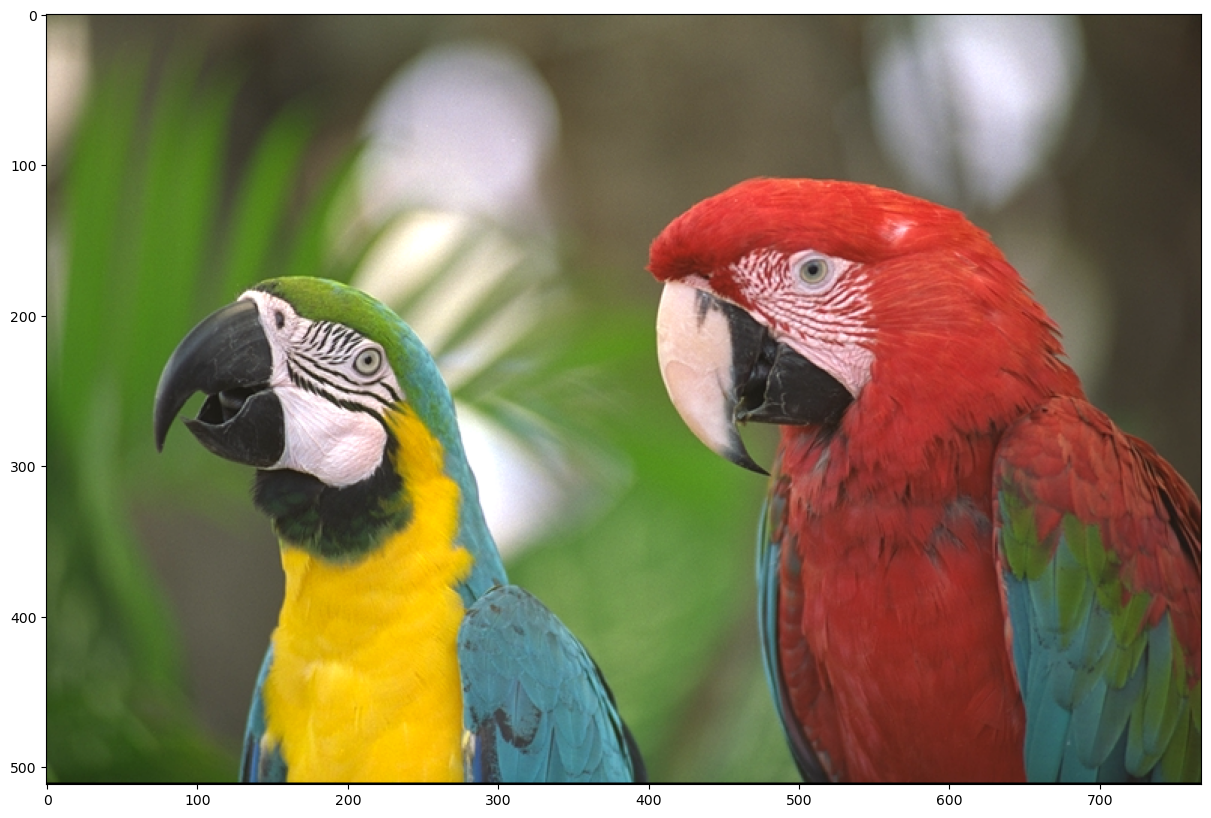

In [3]:
# Load image
img = cv2.imread('kodim23.png')
# Convert it to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Plot it
plt.imshow(img)

Let's start with gray tones first.

In [4]:
# Black, dark gray, light gray, white
colors = np.array([[0, 0, 0],
                   [64, 64, 64],
                   [192, 192, 192],
                   [255, 255, 255]])

Using the colour pallette, let's quantize the original image.

In [5]:
# Cast the image to float
img = img.astype(np.float32)
    
def color_distance(rgb1, rgb2):
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2

    return math.sqrt(
        (r1 - r2) ** 2
      + (g1 - g2) ** 2
      + (b1 - b2) ** 2)

def color_distanceEx(rgb1, rgb2):
    r1, g1, b1 = rgb1
    r2, g2, b2 = rgb2

    return math.sqrt(
        (rgb1[0] - rgb2[0]) ** 2
      + (rgb1[1] - rgb2[1]) ** 2
      + (rgb1[2] - rgb2[2]) ** 2)

def nearest_palette(palette, clr):
    result = palette[0]
    bestValue = 100000000
    
    for value in palette:
        dist = color_distance(value, clr)
        if dist < bestValue:
            bestValue = dist
            result = value
    return result
  

In [6]:
# Prepare for quantization
def make_quantized(palette, source_img):
    rows, cols, channels = source_img.shape
    result = np.zeros_like(source_img)

    # Apply quantization
    for r in tqdm(range(rows)):
        for c in range(cols):
            # Extract the original pixel value
            pixel = list(source_img[r, c, :])
        
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here

            new_pixel =  nearest_palette(palette, pixel)
        
            # Apply quantization
            result[r, c, :] = new_pixel
    return result

In [7]:
quantized = make_quantized(colors, img)

100%|██████████| 512/512 [00:08<00:00, 57.82it/s]


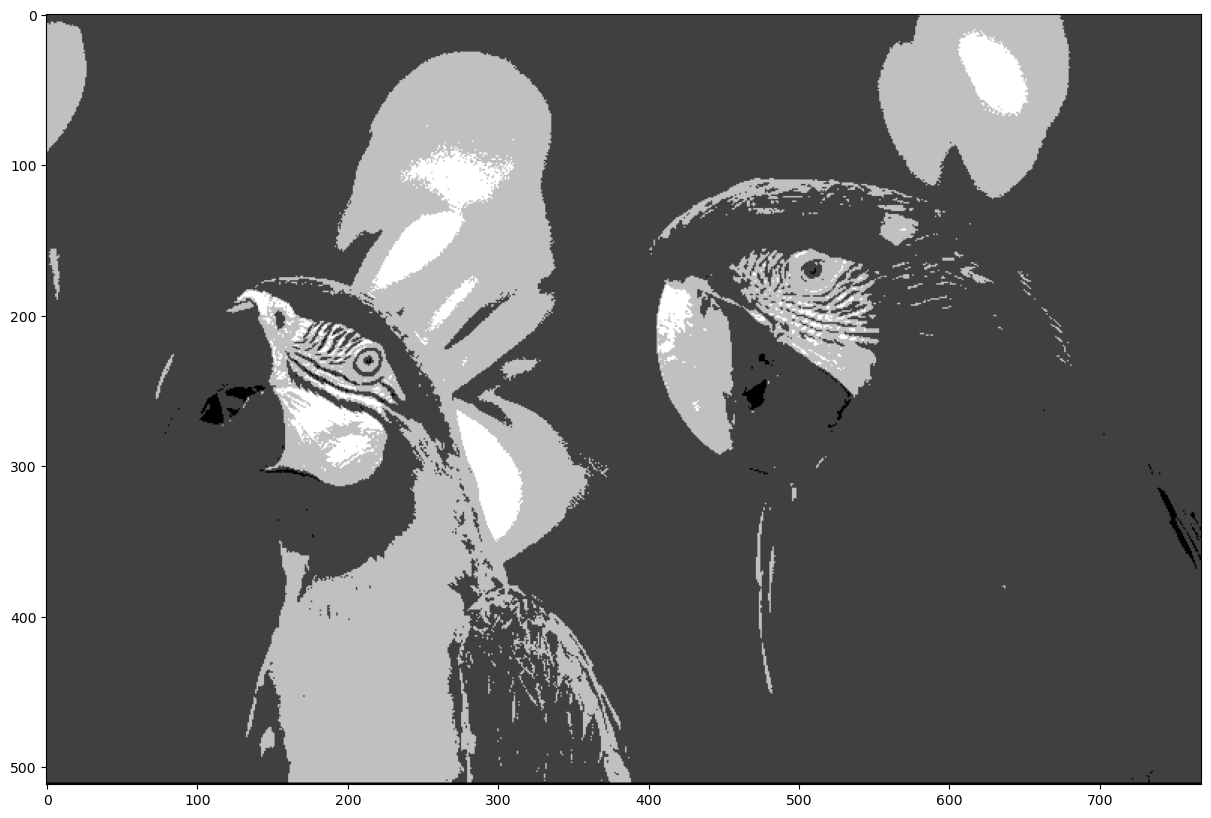

In [8]:
# Show quantized image (don't forget to cast back to uint8)
plt.imshow(quantized.astype(np.uint8))

In [9]:
# Compute average quantization error
def mse(ref, target):
    error = ref.astype(np.float32) - target.astype(np.float32)
    return np.mean(error**2)

print('quant MSE', mse(img, quantized))

quant MSE 2140.2979


#### Floyd-Steinberg Dithering
We are now going to implement the FS dithering and compare it to the optimally quantized image we have calculated above.

In [10]:
# Make a temporal copy of the original image, we will need it for error diffusion
def make_dithering(palette, source_img):
    img_tmp = np.copy(source_img)
    result = np.zeros_like(source_img)
    rows, cols, channels = source_img.shape

    for r in tqdm(range(1, rows-1)):
        for c in range(1, cols-1):
            # Extract the original pixel value
            pixel = list(img_tmp[r, c, :])
            # Find the closest colour from the pallette (using absolute value/Euclidean distance)
            # Note: You may need more than one line of code here
            new_pixel = nearest_palette(palette, pixel)        
        
            # Compute quantization error
            quant_error = pixel - new_pixel
            # Diffuse the quantization error accroding to the FS diffusion matrix
            # Note: You may need more than one line of code here

            img_tmp[r + 1][c    ] = img_tmp[r + 1][c    ] + quant_error * 7 / 16
            img_tmp[r - 1][c + 1] = img_tmp[r - 1][c + 1] + quant_error * 3 / 16
            img_tmp[r    ][c + 1] = img_tmp[r    ][c + 1] + quant_error * 5 / 16
            img_tmp[r + 1][c + 1] = img_tmp[r + 1][c + 1] + quant_error * 1 / 16
          
            # Apply dithering
            result[r, c, :] = new_pixel
    return result

In [11]:
dithering = make_dithering(colors, img)


100%|██████████| 510/510 [00:15<00:00, 33.18it/s]


(<Axes: >, <matplotlib.image.AxesImage at 0x1a78dd3d6a0>)

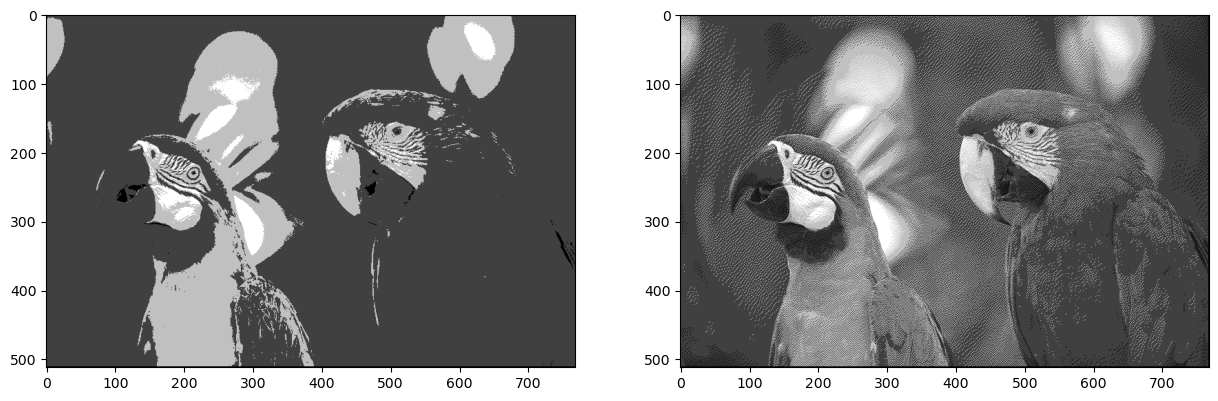

In [12]:
# Show quantized image (don't forget to cast back to uint8)
plt.subplot(121), plt.imshow(quantized.astype(np.uint8))   # optimally quantized
plt.subplot(122), plt.imshow(dithering.astype(np.uint8))   # dithering

In [13]:
# Compute average quantization error for dithered image
print('dithering MSE', mse(img, dithering))

dithering MSE 3060.137


### Questions
* Which image has higher quantization error? Optimally quantized or dithered?
*   -- квантизация показывает меньший MSE но визуально лучше выгладит dithering
* Which image looks better to you?
*   -- dithering однозначно
  
* Can you repeat the same process using only two colours: black and white? Show me :-)


100%|██████████| 510/510 [00:11<00:00, 45.96it/s]


quant MSE 8596.012
dithering MSE 14342.077


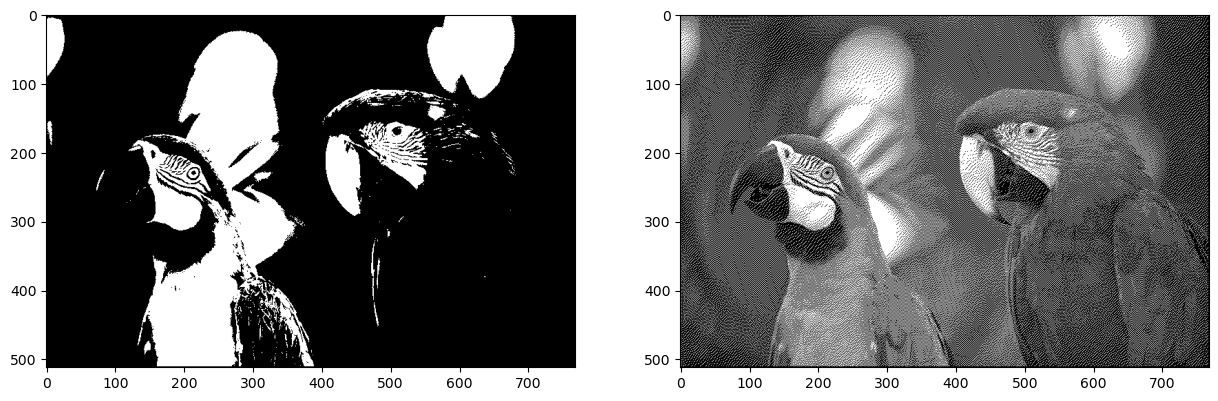

In [14]:
colors2 = np.array([[0, 0, 0],
               [255, 255, 255]])

quantized2 = make_quantized(colors2, img)
dithering2 = make_dithering(colors2, img)
plt.subplot(121), plt.imshow(quantized2.astype(np.uint8))
plt.subplot(122), plt.imshow(dithering2.astype(np.uint8))

print('quant MSE', mse(img, quantized2))
print('dithering MSE', mse(img, dithering2))

### Bonus Points

Repeat the homework using a diffrerent image pallette. For instance, you can use an optimal colour
pallette that we can calculate via k-means algorithm. The following snippet of code will give you the 16
optimal colours for your original image.

In [ ]:
from sklearn.cluster import KMeans
reshaped = np.reshape(img, (-1, 3))
kmeans = KMeans(n_clusters=16).fit(reshaped)

# Grayscale mode
#reshaped = np.reshape(img, (-1, 1))
#kmeans = KMeans(n_clusters=16).fit(reshaped)
#colorsOptimal = np.hstack( (kmeans.cluster_centers_, kmeans.cluster_centers_, kmeans.cluster_centers_) )

colorsOptimal = kmeans.cluster_centers_
print(colorsOptimal)


In [23]:
reshaped.shape

(393216, 3)

100%|██████████| 510/510 [00:27<00:00, 18.53it/s]


quant MSE 140.38008
dithering MSE 286.49255


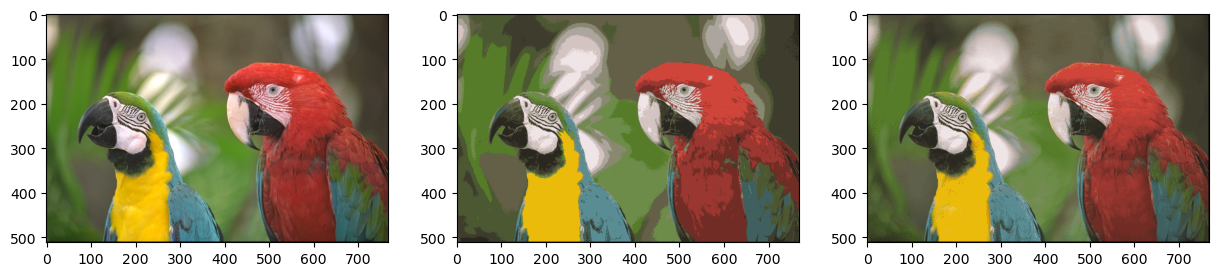

In [24]:
quantized3 = make_quantized(colorsOptimal, img)
dithering3 = make_dithering(colorsOptimal, img)
plt.subplot(131), plt.imshow(img.astype(np.uint8))
plt.subplot(132), plt.imshow(quantized3.astype(np.uint8))
plt.subplot(133), plt.imshow(dithering3.astype(np.uint8))

print('quant MSE', mse(img, quantized3))
print('dithering MSE', mse(img, dithering3))

Apply FS dithering the same way you did before.
* How does the result look like to you?
  в случае dithering картинка выглядит почти идеально!
  
* What happens if we use 32 colours?
* And what happens if we use 256 colours?
        соотевтственно получим еще лучшие результаты
